## Importing Libraries

In [1]:
import json
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification
from tqdm import tqdm

## Importing the Data

In [2]:
# Step 1: Load the JSON file
with open("dunya_china_framed_articles_final.json", "r", encoding="utf-8") as f:
    data = json.load(f)

In [3]:
# Just keep first 500 articles for now (Run this if you want to perform the task with a sample)
#data_subset = data[:500]
data_subset = data
texts = [item["all_texts"] for item in data_subset]

In [4]:
# Convert to DataFrame
df = pd.DataFrame(data_subset)

# Now check unique values of the "year" column
print(df["year"].unique())

['2013' '2016' '2020' '2014' '2017' '2021' '2008' '2015' '2018' '2010'
 '2011' '2019' '2009' '2012' '2022']


In [5]:
# Count number of observations per year
year_counts = df["year"].value_counts().sort_index()

# Display the result
print(year_counts)


year
2008     959
2009     959
2010    1126
2011     865
2012    1173
2013    1379
2014    1574
2015    1956
2016    1786
2017    2014
2018    1803
2019    1621
2020    2359
2021    1965
2022     738
Name: count, dtype: int64


## Model Initialization

In [6]:
model_path = "/content/bert_model_economicrelationship_optimized_dual.pth"


# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load tokenizer and model config
tokenizer = BertTokenizer.from_pretrained("dbmdz/bert-base-turkish-128k-cased")
model = BertForSequenceClassification.from_pretrained(
    "dbmdz/bert-base-turkish-128k-cased",
    num_labels=2  # or 3, depending on your setup
)

# Load weights (assuming it was saved using model.state_dict())
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)
model.eval()


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/60.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.18M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/386 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/740M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dbmdz/bert-base-turkish-128k-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(128000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1

In [7]:

# Step 4: Dataset and DataLoader
class ArticleDataset(Dataset):
    def __init__(self, texts, tokenizer, max_length=512):
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoded = self.tokenizer(
            self.texts[idx],
            padding='max_length',
            truncation=True,
            max_length=self.max_length,
            return_tensors='pt'
        )
        return {
            'input_ids': encoded['input_ids'].squeeze(),
            'attention_mask': encoded['attention_mask'].squeeze()
        }

# Step 4: DataLoader for batch prediction
dataset = ArticleDataset(texts, tokenizer)
dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

# Step 5: Predict
all_preds = []
with torch.no_grad():
    for batch in tqdm(dataloader):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1)
        all_preds.extend(preds.cpu().tolist())

100%|██████████| 697/697 [05:05<00:00,  2.28it/s]


## Saving the Results

In [8]:
import re

# Step 1: Add predictions to the original JSON-style list of dicts
for article, pred in zip(data, all_preds):
    article["prediction"] = int(pred)

# Step 2: Save updated JSON
with open("dunya_predicted_articles.json", "w", encoding="utf-8") as f:
    json.dump(data, f, ensure_ascii=False, indent=2)

print("✅ Saved predicted results to 'dunya_predicted_articles.json'")

# Step 3: Convert to DataFrame
data_subset = pd.DataFrame(data)

# Step 4: Remove illegal characters from Excel-incompatible cells
def remove_illegal_chars(text):
    if isinstance(text, str):
        return re.sub(r"[\x00-\x1F\x7F]", "", text)
    return text

for col in data_subset.select_dtypes(include=["object"]):
    data_subset[col] = data_subset[col].map(remove_illegal_chars)

# Step 5: Save to Excel
data_subset.to_excel("dunya_predicted_articles.xlsx", index=False)
print("✅ Saved cleaned DataFrame to 'dunya_predicted_articles.xlsx'")


✅ Saved predicted results to 'dunya_predicted_articles.json'
✅ Saved cleaned DataFrame to 'dunya_predicted_articles.xlsx'


## Taking a Random Sample for Observing the Performance of the Model

In [9]:
data_subset.head()

,published_date,update,category,url,title,abstract,content,language,docname,yatırım,predicted_label1,year,all_texts,prediction
0,2013-06-24 14:20:20+00:00,2013-06-24T17:20:20+03:00,gundem,https://www.dunya.com/gundem/new-york-borsasi-...,New York borsası sert düşüşle açıldı,,İSTANBUL - Çin'deki nakit sıkışıklığı ve Goldm...,turkish,text166002,-0.5618,1,2013,New York borsası sert düşüşle açıldıİSTANBUL -...,0
1,2016-12-26 06:45:00+00:00,2016-12-26T09:45:00+03:00,finans_haberler,https://www.dunya.com/finans/haberler/dis-bors...,Dış borsalarda Noel rehaveti,"Küresel piyasalar, Noel tatili dolayısıyla kap...","Asya, Avrupa ile Kuzey ve Güney Amerika kıtası...",turkish,text166037,0.0724,1,2016,"Dış borsalarda Noel rehavetiKüresel piyasalar,...",0
2,2020-02-20 14:56:00+00:00,2020-02-20T17:56:00+03:00,finans_haberler,https://www.dunya.com/finans/haberler/abdde-en...,ABD'de endeksler düşüşle açıldı,"New York borsası, perşembe gününe düşüşle başl...","New York borsasında endeksler, perşembe gününe...",turkish,text166112,-0.7376,1,2020,ABD'de endeksler düşüşle açıldıNew York borsas...,0
3,2014-04-30 12:27:54+00:00,2014-04-30T15:27:54+03:00,sektorler_tekstil,https://www.dunya.com/sektorler/tekstil/cin039...,"Çin'de lüks tüketiminin artması, Türk hazır gi...","UHKİB Başkanı Şankaya, Türkiye'nin, Avrupa ülk...",BURSA - Uludağ Hazır Giyim ve Konfeksiyon İhra...,turkish,text166114,0.1311,1,2014,"Çin'de lüks tüketiminin artması, Türk hazır gi...",1
4,2017-04-05 21:54:00+00:00,2017-04-06T00:54:00+03:00,dunya,https://www.dunya.com/dunya/nepalde-turk-isada...,Nepal’de Türk işadamları için 7 yatırım fırsatı,"Nepal, 2022 yılında gelişmekte olan ülkeler sı...",İSTANBUL (DÜNYA) - Nepal’in başkenti Katmandu’...,turkish,text166131,1.3429,1,2017,Nepal’de Türk işadamları için 7 yatırım fırsat...,0


In [10]:
data_subset.iloc[0, 8]

'text166002'

In [11]:
# Filter separately by prediction values
subset_1 = data_subset[data_subset['prediction'] == 1].sample(n=50, random_state=42)
subset_0 = data_subset[data_subset['prediction'] == 0].sample(n=50, random_state=42)

# Concatenate them into one dataframe
sample_data_subset = pd.concat([subset_1, subset_0]).sample(frac=1, random_state=42).reset_index(drop=True)

In [12]:
sample_data_subset.to_excel("sample_data_subset_dunya.xlsx", index=False)

## Visualising the results

<ipython-input-13-bde12bc87a63>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_positive["year"] = df_positive["year"].astype(int)


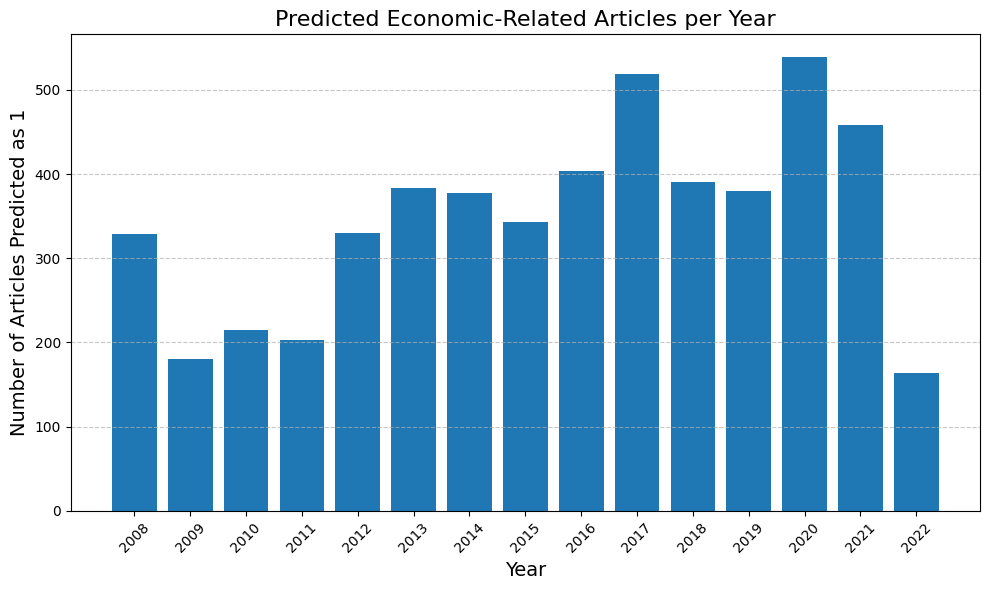

In [13]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert JSON subset (with prediction and year) to DataFrame
df = pd.DataFrame(data_subset)

# Ensure prediction is integer
df["prediction"] = df["prediction"].astype(int)

# Filter for only predictions == 1
df_positive = df[df["prediction"] == 1]

# Convert year to int
df_positive["year"] = df_positive["year"].astype(int)

# Count number of positive articles per year
year_counts = df_positive["year"].value_counts().sort_index()

# Auto-generate full year range based on existing data
min_year = df_positive["year"].min()
max_year = df_positive["year"].max()
full_year_range = range(min_year, max_year + 1)

# Reindex to ensure all years appear, even if count is 0
year_counts = year_counts.reindex(full_year_range, fill_value=0)

# Plot
plt.figure(figsize=(10, 6))
plt.bar(year_counts.index, year_counts.values)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Number of Articles Predicted as 1", fontsize=14)
plt.title("Predicted Economic-Related Articles per Year", fontsize=16)
plt.xticks(year_counts.index, rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
